In [ ]:
# from google.colab import drive
# drive.mount("/content/drive/",force_remount=True)

Mounted at /content/drive/


In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score

ModuleNotFoundError: ignored

In [ ]:
import pandas as pd
import re
df=pd.read_csv("PoetryFoundationData.csv", error_bad_lines = False, engine = "python" )
df.head()

<ipython-input-3-69e5e2a6ffbb>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df=pd.read_csv("PoetryFoundationData.csv", error_bad_lines = False, engine = "python" )
Skipping line 714: unexpected end of data


,Unnamed: 0,Title,Poem,Poet,Tags
0,0,\n\n Objects Used to Prop O...,"\n\nDog bone, stapler,\n\ncribbage board, garl...",Michelle Menting,NaN
1,1,\n\n The New Church\n\n ...,"\n\nThe old cupola glinted above the clouds, s...",Lucia Cherciu,NaN
2,2,\n\n Look for Me\n\n ...,\n\nLook for me under the hood\n\nof that old ...,Ted Kooser,NaN
3,3,\n\n Wild Life\n\n ...,"\n\nBehind the silo, the Mother Rabbit\n\nhunc...",Grace Cavalieri,NaN
4,4,\n\n Umbrella\n\n ...,\n\nWhen I push your button\n\nyou fly off the...,Connie Wanek,NaN


In [ ]:
for i in range(len(df)):
  df.loc[i,"Title"]=str(df.loc[i,"Title"].strip())
  df.loc[i,"Poem"]=str(df.loc[i,"Poem"].strip())
  df.loc[i,"Poem"]=re.sub(r"\r|\n","",str(df.loc[i,"Poem"]))
  df.loc[i,"Poem"]=re.sub("\.|\,|\;","",str(df.loc[i,"Poem"]))

In [ ]:
df=df.drop(columns=["Unnamed: 0","Title","Tags"])

In [ ]:
counts=[]
for i in set(df["Poet"]):
  num=list(df["Poet"]).count(i)
  counts.append([i,num])

In [ ]:
counts.sort(key=lambda f:f[1],reverse=True)

In [ ]:
poets=["William Shakespeare","Alfred, Lord Tennyson","Emily Dickinson","William Wordsworth","William Butler Yeats"]

In [ ]:
d=dict()
d["Poem"]=[]
d["Poet"]=[]

for i in range(len(df)):
  if df.loc[i,"Poet"] in poets:
    d["Poem"].append(df.loc[i,"Poem"])
    d["Poet"].append(df.loc[i,"Poet"])

In [ ]:
new_df=pd.DataFrame(d)

In [ ]:
import os
os.mkdir("data/")
os.mkdir("data/train/")
os.mkdir("data/test/")
os.mkdir("data/val/")

In [ ]:
for dt in ["train","test","val"]:
  for poet in poets:
    os.mkdir(f"data/{dt}/{poet}/")

FileExistsError: ignored

,Poem,Poet
0,Dog bone staplercribbage board garlic press ...,Michelle Menting
1,The old cupola glinted above the clouds shonea...,Lucia Cherciu
2,Look for me under the hoodof that old Chevrole...,Ted Kooser
3,Behind the silo the Mother Rabbithunches like ...,Grace Cavalieri
4,When I push your buttonyou fly off the handleo...,Connie Wanek


(712, 2)

In [ ]:
from sklearn.model_selection import train_test_split
train_dataset,val_dataset=train_test_split(data,test_size=0.4)
test_dataset,val_dataset=train_test_split(val_dataset,test_size=0.5)
train_dataset.reset_index(drop=True,inplace=True)
test_dataset.reset_index(drop=True,inplace=True)
val_dataset.reset_index(drop=True,inplace=True)

In [ ]:
for dt,nm in [[train_dataset,"train"],[test_dataset,"test"],[val_dataset,"val"]]:
  for i in range(len(dt)):
    poet=dt.loc[i,"Poet"]
    with open(f"data/{nm}/{poet}/{i}.txt","w") as f:
      f.write(dt.loc[i,"Poem"])
    f.close()


FileNotFoundError: ignored

In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git


In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 128

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {poets[i]:i for i in range(len(poets))}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)


In [ ]:
class PoetryClassifier(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):

    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    self.texts = []
    self.labels = []
    # Since the labels are defined by folders with data we loop
    # through each label.
    for label in poets:
      sentiment_path = os.path.join(path, label)

      # Get all files from path.
      files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
      # Go through each file and read its content.
      for file_name in tqdm(files_names, desc=f'{label} files'):
        file_path = os.path.join(sentiment_path, file_name)

        # Read content.
        content = io.open(file_path, mode='r', encoding='utf-8').read()
        # Fix any unicode issues.
        content = fix_text(content)
        # Save content.
        self.texts.append(content)
        # Save encode labels.
        self.labels.append(label)

    # Number of exmaples.
    self.n_examples = len(self.labels)


    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """

    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.

    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask.

    It uses a given tokenizer and label encoder to convert any text and labels to numbers that
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here:
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss


In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)


In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = PoetryClassifier(path="data/train/",
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  PoetryClassifier(path="data/val/",
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))


In [ ]:
test_dataset =  PoetryClassifier(path="data/test/",
                               use_tokenizer=tokenizer)
print('Created `test_dataset` with %d examples!'%len(test_dataset))
test_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))


Epoch


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 6.78389 - val_loss: 4.56259 - train_acc: 0.06667 - valid_acc: 0.19048


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 4.92268 - val_loss: 3.10444 - train_acc: 0.13333 - valid_acc: 0.28571


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 2.78885 - val_loss: 1.96043 - train_acc: 0.26667 - valid_acc: 0.42857


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 2.61417 - val_loss: 2.10810 - train_acc: 0.30000 - valid_acc: 0.28571


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 2.11810 - val_loss: 1.51894 - train_acc: 0.30000 - valid_acc: 0.47619


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.40133 - val_loss: 1.47133 - train_acc: 0.43333 - valid_acc: 0.47619


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.46578 - val_loss: 1.32181 - train_acc: 0.26667 - valid_acc: 0.42857


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.19731 - val_loss: 1.32792 - train_acc: 0.58333 - valid_acc: 0.42857


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.10027 - val_loss: 1.19815 - train_acc: 0.51667 - valid_acc: 0.57143


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.95221 - val_loss: 1.15098 - train_acc: 0.65000 - valid_acc: 0.52381


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.86915 - val_loss: 1.13712 - train_acc: 0.66667 - valid_acc: 0.52381


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.76940 - val_loss: 1.20772 - train_acc: 0.65000 - valid_acc: 0.52381


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.81968 - val_loss: 1.33334 - train_acc: 0.78333 - valid_acc: 0.52381


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.61714 - val_loss: 1.16047 - train_acc: 0.71667 - valid_acc: 0.47619


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.48236 - val_loss: 1.15234 - train_acc: 0.86667 - valid_acc: 0.52381


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.49076 - val_loss: 1.12640 - train_acc: 0.81667 - valid_acc: 0.52381


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.57663 - val_loss: 1.10164 - train_acc: 0.91667 - valid_acc: 0.61905


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.29878 - val_loss: 1.23287 - train_acc: 0.95000 - valid_acc: 0.52381


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.28156 - val_loss: 1.42675 - train_acc: 0.91667 - valid_acc: 0.47619


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.25945 - val_loss: 1.41927 - train_acc: 0.90000 - valid_acc: 0.47619


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.18371 - val_loss: 1.30917 - train_acc: 0.95000 - valid_acc: 0.47619


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.12719 - val_loss: 1.25000 - train_acc: 1.00000 - valid_acc: 0.57143


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.08468 - val_loss: 1.29887 - train_acc: 1.00000 - valid_acc: 0.61905


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.05592 - val_loss: 1.38947 - train_acc: 1.00000 - valid_acc: 0.57143


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.05380 - val_loss: 1.55384 - train_acc: 1.00000 - valid_acc: 0.52381


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.04214 - val_loss: 1.82596 - train_acc: 0.98333 - valid_acc: 0.52381


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.03036 - val_loss: 1.66292 - train_acc: 1.00000 - valid_acc: 0.52381


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.03584 - val_loss: 1.55803 - train_acc: 0.98333 - valid_acc: 0.57143


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.01529 - val_loss: 1.44906 - train_acc: 1.00000 - valid_acc: 0.66667


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.01628 - val_loss: 1.38880 - train_acc: 1.00000 - valid_acc: 0.76190


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.01803 - val_loss: 1.38259 - train_acc: 1.00000 - valid_acc: 0.71429


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.01044 - val_loss: 1.43336 - train_acc: 1.00000 - valid_acc: 0.71429


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00964 - val_loss: 1.49755 - train_acc: 1.00000 - valid_acc: 0.71429


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.01178 - val_loss: 1.57236 - train_acc: 1.00000 - valid_acc: 0.71429


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00446 - val_loss: 1.64419 - train_acc: 1.00000 - valid_acc: 0.66667


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00364 - val_loss: 1.70683 - train_acc: 1.00000 - valid_acc: 0.61905


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00785 - val_loss: 1.81274 - train_acc: 1.00000 - valid_acc: 0.57143


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00320 - val_loss: 1.90513 - train_acc: 1.00000 - valid_acc: 0.57143


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00704 - val_loss: 1.86217 - train_acc: 1.00000 - valid_acc: 0.57143


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00293 - val_loss: 1.83085 - train_acc: 1.00000 - valid_acc: 0.57143


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00354 - val_loss: 1.81488 - train_acc: 1.00000 - valid_acc: 0.61905


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00166 - val_loss: 1.80291 - train_acc: 1.00000 - valid_acc: 0.66667


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00215 - val_loss: 1.79522 - train_acc: 1.00000 - valid_acc: 0.66667


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00215 - val_loss: 1.78492 - train_acc: 1.00000 - valid_acc: 0.66667


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00144 - val_loss: 1.78023 - train_acc: 1.00000 - valid_acc: 0.66667


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00179 - val_loss: 1.77695 - train_acc: 1.00000 - valid_acc: 0.66667


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00158 - val_loss: 1.77626 - train_acc: 1.00000 - valid_acc: 0.66667


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00386 - val_loss: 1.78011 - train_acc: 1.00000 - valid_acc: 0.66667


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00181 - val_loss: 1.78298 - train_acc: 1.00000 - valid_acc: 0.66667


Training on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.00222 - val_loss: 1.78456 - train_acc: 1.00000 - valid_acc: 0.66667



/usr/local/lib/python3.9/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


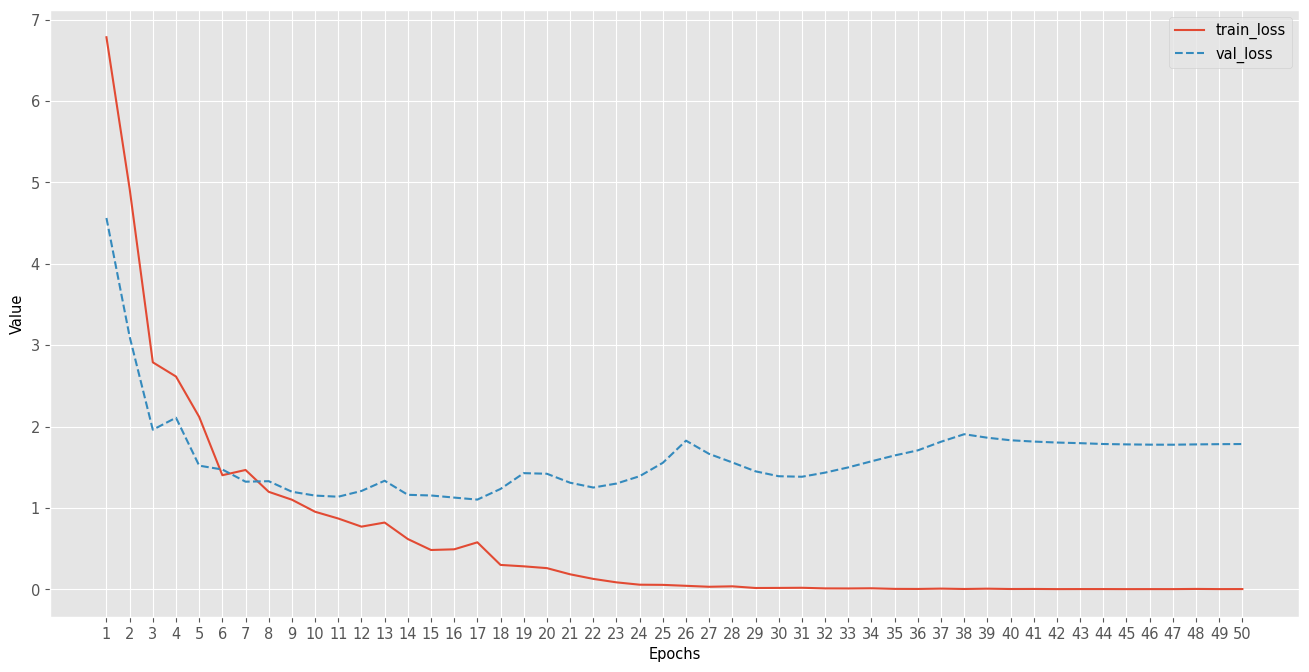

/usr/local/lib/python3.9/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


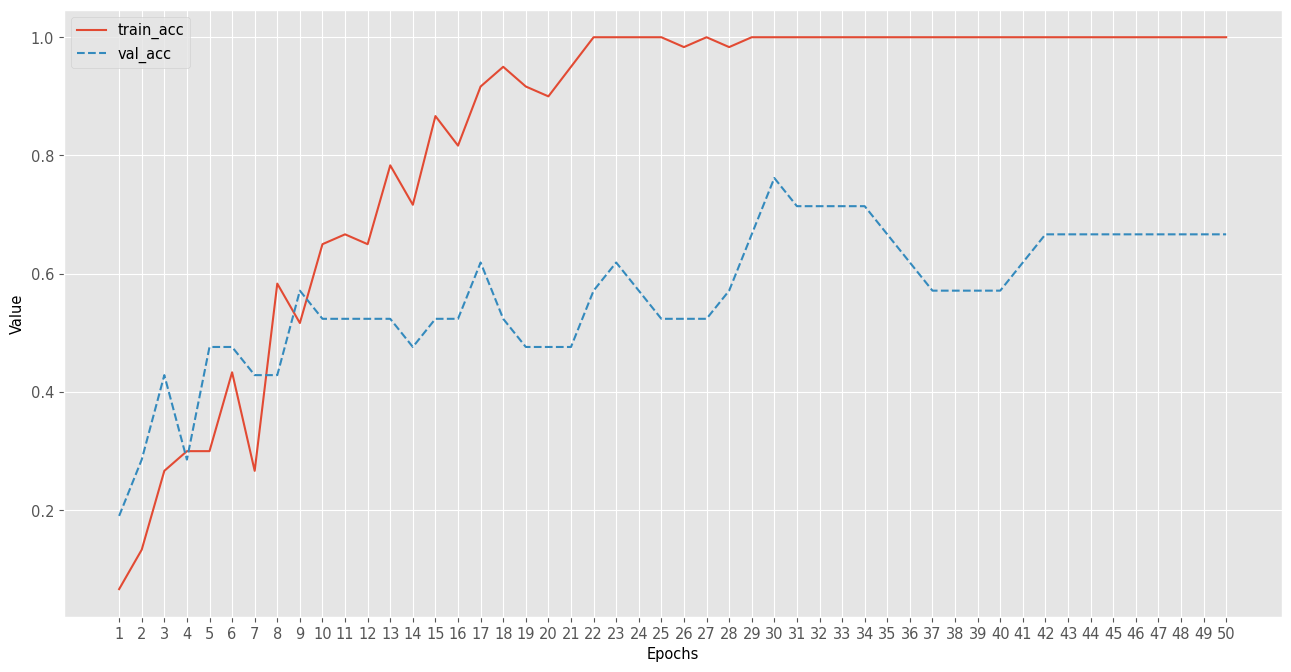

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-4, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-6 # default is 1e-8.
                  )
epochs=50

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

  William Shakespeare       0.86      0.67      0.75         9
Alfred, Lord Tennyson       0.00      0.00      0.00         1
      Emily Dickinson       1.00      0.80      0.89         5
   William Wordsworth       0.00      0.00      0.00         1
 William Butler Yeats       0.40      0.80      0.53         5

             accuracy                           0.67        21
            macro avg       0.45      0.45      0.43        21
         weighted avg       0.70      0.67      0.66        21

Normalized confusion matrix


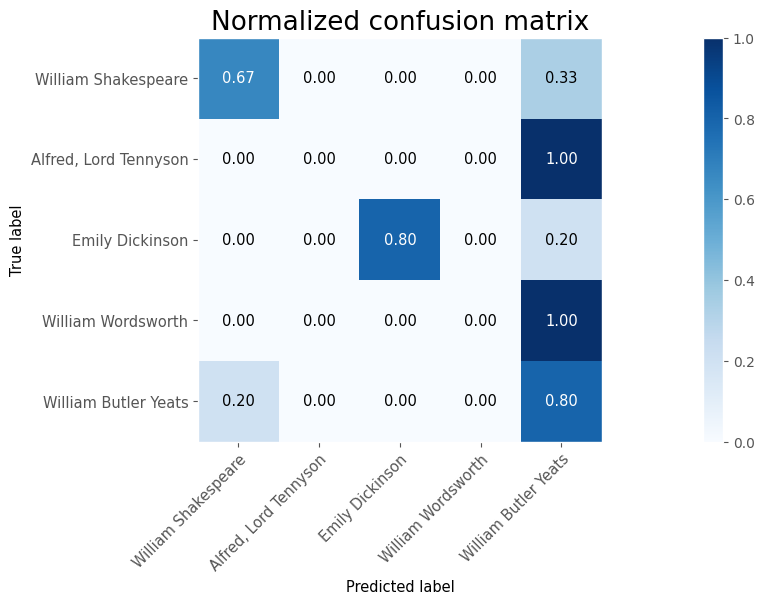

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=0.1,
                      );


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_pretrained("drive/MyDrive/AMLproj/Model1_GPT2")
tokenizer.save_pretrained("drive/MyDrive/AMLproj/Tokenizer1_GPT2")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('drive/MyDrive/AMLproj/Tokenizer1_GPT2/tokenizer_config.json',
 'drive/MyDrive/AMLproj/Tokenizer1_GPT2/special_tokens_map.json',
 'drive/MyDrive/AMLproj/Tokenizer1_GPT2/vocab.json',
 'drive/MyDrive/AMLproj/Tokenizer1_GPT2/merges.txt',
 'drive/MyDrive/AMLproj/Tokenizer1_GPT2/added_tokens.json')

In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("drive/MyDrive/AMLproj/Model1_GPT2")
tokenizer = AutoTokenizer.from_pretrained("drive/MyDrive/AMLproj/Tokenizer1_GPT2")


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Some weights of the model checkpoint at drive/MyDrive/AMLproj/Model1_GPT2 were not used when initializing GPT2LMHeadModel: ['score.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_text = "The quick brown fox jumps over the lazy dog"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
generated_text = model.generate(input_ids, max_length=100, num_beams=5, no_repeat_ngram_size=2)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
generated_text

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[  464,  2068,  7586, 21831, 18045,   625,   262, 16931,  3290,    13,
           198,   198,   464,  3049,  7586,  3290,  3011,  3492,   284,   467,
            13, 50256]])

ModuleNotFoundError: ignored

In [ ]:
!pip install BertTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement BertTokenizer (from versions: none)
ERROR: No matching distribution found for BertTokenizer
